In [30]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from denoising_diffusion_pytorch import Unet1D, GaussianDiffusion1D, Trainer1D, Dataset1D

# Choice number of Gaussians + Standard DDPM

In [31]:
num_gaussians = 3
num_points = 6000
mode = "training"
num_epochs = 5000
std_data = 0.05

In [32]:
def gauss_train_dataset(num_gaussians, num_points):

    means = torch.linspace(0, 1, num_gaussians * 2 + 1)
    stds = std_data/num_gaussians

    training_data = []

    for i in range(num_gaussians):
        single_gauss_shape = num_points // num_gaussians
        single_gauss = torch.normal(means[2*i+1], stds, (single_gauss_shape,))
        training_data.append(single_gauss)
    stacked_data = torch.cat(training_data)
    return stacked_data.unsqueeze(-1).unsqueeze(-1)

def plot_dataset(training_seq, title):
    
    hist = plt.hist(training_seq[:,0], bins = 100)
    plt.xlim(0,1)
    plt.title(title)

Shape:  torch.Size([6000, 1, 1])


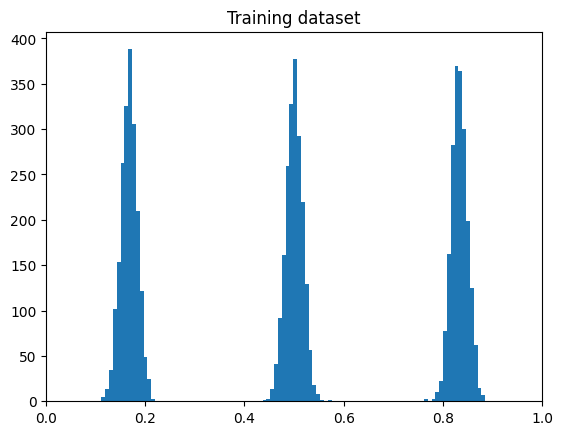

In [33]:
training_seq = gauss_train_dataset(num_gaussians, num_points)
print("Shape: ", training_seq.shape)
plot_dataset(training_seq, "Training dataset")

In [ ]:
model = Unet1D(
    dim = 64,
    dim_mults = (1, ),
    channels = 1
)

diffusion = GaussianDiffusion1D(
    model,
    seq_length = 1,
    timesteps = 1000,
    objective = 'pred_v'
)

# Using trainer

dataset = Dataset1D(training_seq)  # this is just an example, but you can formulate your own Dataset and pass it into the `Trainer1D` below

trainer = Trainer1D(
    diffusion,
    dataset = dataset,
    train_batch_size = 32,
    train_lr = 8e-5,
    train_num_steps = num_epochs,         # total training steps
    save_and_sample_every = 100000, # gets saved to "results" folder (disable with high save_and_sample_every)
    gradient_accumulate_every = 2,    # gradient accumulation steps
    ema_decay = 0.995,                # exponential moving average decay
    amp = True,                       # turn on mixed precision
)

if mode == "continuing":
    state_dict = torch.load(f"model_checkpoints/{num_gaussians}D_gauss_6000.pt", map_location="cpu")
    model.load_state_dict(state_dict)

    trainer.train()

    torch.save(
        model.state_dict(),
        f"model_checkpoints/{num_gaussians}D_gauss_8000.pt"
    ) 

if mode == "training":
    trainer.train()

    torch.save(
        model.state_dict(),
        f"model_checkpoints/{num_gaussians}D_gauss_{num_epochs}_{std_data}.pt"
    ) 


Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/n/home00/zoewu/.conda/envs/parallel_toy/lib/python3.10/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/5000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

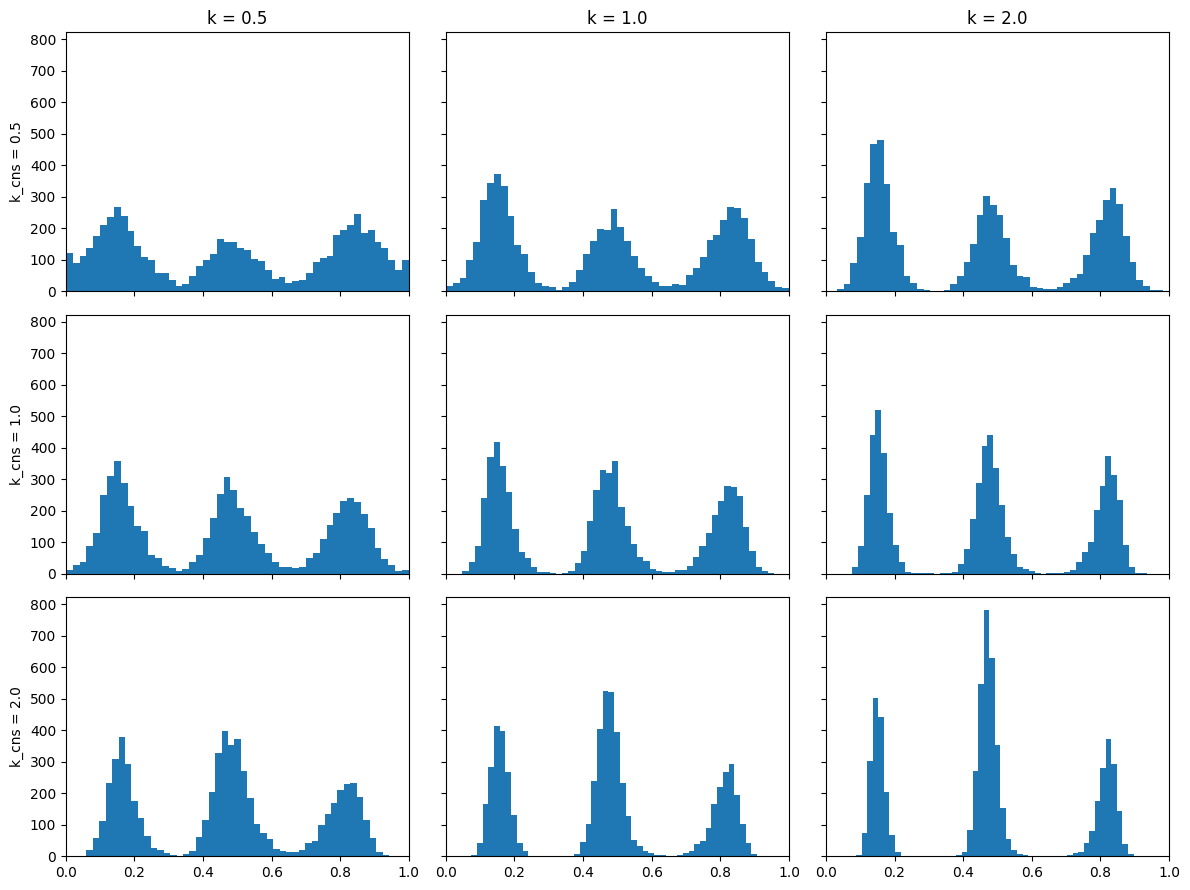

In [22]:
k_list = [0.5, 1.0, 2.0]
k_cns_list = [0.5, 1.0, 2.0]

fig, axes = plt.subplots(
    nrows=len(k_cns_list),
    ncols=len(k_list),
    figsize=(4 * len(k_list), 3 * len(k_cns_list)),
    sharex=True,
    sharey=True
)

for i, k_cns in enumerate(k_cns_list):
    for j, k in enumerate(k_list):
        ax = axes[i, j] if len(k_cns_list) > 1 else axes[j]

        sampled_seq = diffusion.sample(
            k=k,
            k_cns=k_cns,
            batch_size=num_points
        )
        sampled_seq_np = sampled_seq.detach().cpu().numpy()

        ax.hist(sampled_seq_np[:, 0], bins=50)
        ax.set_xlim(0.0, 1.0)

        if i == 0:
            ax.set_title(f"k = {k}")
        if j == 0:
            ax.set_ylabel(f"k_cns = {k_cns}")

plt.tight_layout()
plt.show()
